Maximum Climb Rate: 2.62 ft/s
Obstacle 1: Distance = 254.95, Force = 5.83e-08
Obstacle 2: Distance = 634.43, Force = 3.58e-09
Step 0: Distance to Obstacle 1 = 253.31, Distance to Obstacle 2 = 629.61

Step 0: Reward = 115.82, Goal Distance = 1192.39, Barrier Distance = 254.95
Obstacle 1: Distance = 253.31, Force = 5.94e-08
Obstacle 2: Distance = 629.61, Force = 3.67e-09
Step 1: Distance to Obstacle 1 = 251.76, Distance to Obstacle 2 = 624.79

Step 1: Reward = 115.74, Goal Distance = 1187.39, Barrier Distance = 253.31
Obstacle 1: Distance = 251.76, Force = 6.06e-08
Obstacle 2: Distance = 624.79, Force = 3.76e-09
Step 2: Distance to Obstacle 1 = 250.30, Distance to Obstacle 2 = 619.97

Step 2: Reward = 115.64, Goal Distance = 1182.39, Barrier Distance = 251.76
Obstacle 1: Distance = 250.30, Force = 6.16e-08
Obstacle 2: Distance = 619.97, Force = 3.85e-09
Step 3: Distance to Obstacle 1 = 248.94, Distance to Obstacle 2 = 615.16

Step 3: Reward = 115.55, Goal Distance = 1177.39, Barrier Dist

<ipython-input-24-6ca47581403b>:247: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(obstacle_positions))  # "tab10" is a colormap with 10 distinct colors


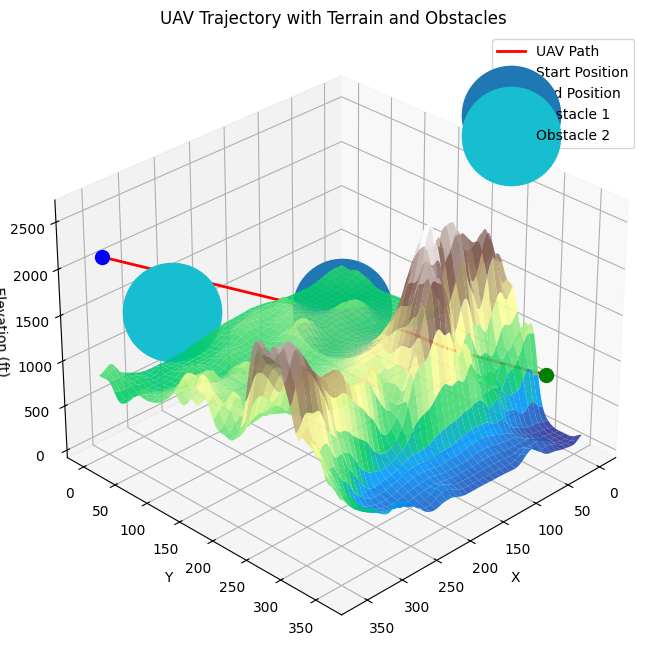

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import rasterio
import matplotlib
#matplotlib.use('qt5agg')  # Or 'tkagg'
import matplotlib.pyplot as plt

# Constants for Potential Fields
k = 5.0  # Attractive scaling
m = 1.0  # Repulsive scaling
rho_0 = 7500.0  # Obstacle influence radius
epsilon = 1e-6  # Small constant for numerical stability
step_size = 5.0
max_steps = 500

# Load Terrain Data
raster = rasterio.open(r'/content/eVTOL_2/USGS_ontario_airport.tif')
elevation_data = raster.read(1)

# Downsample and Smooth Terrain Data
downsample_factor = 30
elevation_data_downsampled = elevation_data[::downsample_factor, ::downsample_factor]
smoothed_elevation = gaussian_filter(elevation_data_downsampled, sigma=5)

# Define X, Y Coordinates
x = np.arange(smoothed_elevation.shape[1])
y = np.arange(smoothed_elevation.shape[0])
x, y = np.meshgrid(x, y)

# Parameters
weight = 43  # UAV weight in lb
sref = 5.67  # Reference wing area in ft²
thrust_available = 113  # Maximum thrust available in lb
rho = 0.0023769  # Air density at sea level in slugs/ft³
velocity = 38.2  # Airspeed in ft/s
safety_buffer = 10  # 10 ft above terrain as a safety margin

# Create UAV Dynamics Instance
uav = UAVDynamics(weight, sref, thrust_available)
climb_rate = uav.compute_climb_rate(rho, velocity)
print(f"Maximum Climb Rate: {climb_rate:.2f} ft/s")

# Start and Target Positions
uav_x, uav_y, uav_z = 50, 350, 1000
endpoint_x, endpoint_y, endpoint_z = 350, 1, 2100
UAV_position = np.array([uav_x, uav_y, uav_z])
goal_position = np.array([endpoint_x, endpoint_y, endpoint_z])
obstacle_positions = [(100.0, 100.0, 1000.0), (300.0, 50.0, 1500.0)]

# Reward Calculation Constants
D_cz = 1000
D_mz = 500
d_max = np.linalg.norm(UAV_position - goal_position)

# Functions
# UAV Dynamics Class
class UAVDynamics:
    def __init__(self, weight, sref, thrust_available):
        self.weight = weight  # UAV weight in lb
        self.sref = sref      # Reference wing area in ft²
        self.thrust_available = thrust_available  # Available thrust in lb
        self.cd = 0.05  # Drag coefficient (assumed constant)

    def compute_climb_rate(self, rho, velocity):
        """Compute maximum climb rate (ft/s)."""
        q = 0.5 * rho * velocity**2  # Dynamic pressure
        drag = q * self.sref * self.cd  # Drag force
        climb_rate = (self.thrust_available - drag) / self.weight  # ft/s
        return climb_rate

def compute_attractive_force(position, goal):
    return k * (goal - position)

def compute_repulsive_force(position, obstacles):
    F_rep = np.array([0.0, 0.0, 0.0])
    for obs in obstacles:
        d_barrier = np.linalg.norm(position - obs)
        if d_barrier <= rho_0:
            d_barrier = max(d_barrier, epsilon)
            F_rep += m * (1 / d_barrier - 1 / rho_0) * (1 / d_barrier**2) * (position - obs) / d_barrier
    return F_rep

    # Function to compute individual repulsive forces
def compute_repulsive_force_separate(position, obstacles):
    F_rep_all = []
    for i, obs in enumerate(obstacles):
        d_barrier = np.linalg.norm(position - obs)
        F_rep = np.array([0.0, 0.0, 0.0])
        if d_barrier <= rho_0:
            d_barrier = max(d_barrier, epsilon)
            F_rep = m * (1 / d_barrier - 1 / rho_0) * (1 / d_barrier**2) * (position - obs) / d_barrier
        F_rep_all.append(np.linalg.norm(F_rep))
        # Correctly indented debug statement
        print(f"Obstacle {i+1}: Distance = {d_barrier:.2f}, Force = {np.linalg.norm(F_rep):.2e}")
    return F_rep_all

def calculate_reward(d_goal, d_barrier, d_max, D_cz, D_mz):
    reward = 0.0
    if d_goal >= D_cz and d_barrier >= D_cz:
        reward += np.tanh((d_max - d_goal) / d_max) * d_goal
    elif D_mz <= d_barrier <= D_cz or D_mz <= d_goal <= D_cz:
        reward += np.tanh((D_cz - d_goal) / D_cz) * d_goal
        reward += np.tanh((D_cz - d_barrier) / D_cz) * d_barrier
    if d_barrier < D_mz:
        reward += np.tanh((D_mz - d_barrier) / D_mz) * d_barrier
    return reward

def get_terrain_elevation(x, y):
    x_idx = np.clip(int(x), 0, smoothed_elevation.shape[1] - 1)
    y_idx = np.clip(int(y), 0, smoothed_elevation.shape[0] - 1)
    return smoothed_elevation[y_idx, x_idx]

def update_position(position, force, step_size):
    return position + step_size * force / np.linalg.norm(force)

def reached_goal(position, goal, tolerance=10.0):
    return np.linalg.norm(position - goal) <= tolerance

def predict_future_positions(position, force, step_size, steps_ahead=2):
    """
    Predict future positions of the UAV based on the current position and force.

    Args:
        position (np.array): Current UAV position (x, y, z).
        force (np.array): Total force acting on the UAV (F_att + F_rep).
        step_size (float): Step size for UAV movement.
        steps_ahead (int): Number of steps to predict ahead.

    Returns:
        list of np.array: Predicted positions for the next 'steps_ahead' moves.
    """
    future_positions = []
    current_position = position.copy()
    normalized_force = force / np.linalg.norm(force)

    for _ in range(steps_ahead):
        current_position = current_position + step_size * normalized_force
        future_positions.append(current_position.copy())

    return future_positions

def get_terrain_elevations_for_future_positions(future_positions, raster_data):
    """
    Get terrain elevations for a list of future UAV positions.

    Args:
        future_positions (list of np.array): Predicted UAV positions.
        raster_data (np.array): Smoothed elevation data.

    Returns:
        list of float: Terrain elevations for the future positions.
    """
    elevations = []
    for pos in future_positions:
        terrain_z = get_terrain_elevation(pos[0], pos[1])
        elevations.append(terrain_z)
    return elevations

# Simulation
trajectory = [UAV_position.copy()]
steps = 0
rewards = []
F_rep_values = []  # Repulsive forces
distance_to_first_obstacle = []  # Distance to the first obstacle
distance_to_second_obstacle = []  # Distance to the second obstacle
F_rep_individual = [[], []]  # One list per obstacle

while steps < max_steps and not reached_goal(UAV_position, goal_position):
    # Current distances
    d_goal = np.linalg.norm(UAV_position - goal_position)
    d_barrier = min(np.linalg.norm(UAV_position - np.array(obs)) for obs in obstacle_positions)
    terrain_z = get_terrain_elevation(UAV_position[0], UAV_position[1])

    # Forces from goal and obstacles
    F_att = compute_attractive_force(UAV_position, goal_position)
    F_rep = compute_repulsive_force(UAV_position, obstacle_positions)
    F_rep_all = compute_repulsive_force_separate(UAV_position, obstacle_positions)


    # Combine forces
    F_total = F_att + F_rep

    # Record individual forces
    for i in range(len(obstacle_positions)):
        F_rep_individual[i].append(F_rep_all[i])

    # Terrain Repulsion Force
    F_rep_terrain = np.array([0.0, 0.0, 0.0])
    if UAV_position[2] < terrain_z + safety_buffer:
        F_rep_terrain = np.array([0, 0, 1]) * (terrain_z + safety_buffer - UAV_position[2])

    # Predict future positions and terrain elevations
    future_positions = predict_future_positions(UAV_position, F_att + F_rep + F_rep_terrain, step_size, steps_ahead=2)
    future_terrain_elevations = get_terrain_elevations_for_future_positions(future_positions, smoothed_elevation)

    # Add terrain repulsion for predicted positions
    F_rep_future = np.array([0.0, 0.0, 0.0])
    for future_pos, future_terrain_z in zip(future_positions, future_terrain_elevations):
        if future_pos[2] < future_terrain_z + safety_buffer:
            F_rep_future += np.array([0, 0, 1]) * (future_terrain_z + safety_buffer - future_pos[2])

    # Total force acting on UAV
    F_total = F_att + F_rep + F_rep_terrain + F_rep_future

    # Update variables
    UAV_position = update_position(UAV_position, F_total, step_size)
    trajectory.append(UAV_position.copy())
    F_rep_values.append(np.linalg.norm(F_rep))  # Record repulsive force magnitude
    distance_to_first_obstacle.append(np.linalg.norm(UAV_position - obstacle_positions[0]))
    distance_to_second_obstacle.append(np.linalg.norm(UAV_position - obstacle_positions[1]))

    # Check if the UAV is outside the influence radius of Obstacle 2
    if distance_to_second_obstacle[-1] > rho_0:
        print(f"Warning: UAV is not within the influence radius of Obstacle 2 (rho_0 = {rho_0})")

    # Debug: Print distances to obstacles
    print(f"Step {steps}: Distance to Obstacle 1 = {distance_to_first_obstacle[-1]:.2f}, Distance to Obstacle 2 = {distance_to_second_obstacle[-1]:.2f}\n")


    # Calculate and Track Reward
    reward = calculate_reward(d_goal, d_barrier, d_max, D_cz, D_mz)
    rewards.append(reward)

    # Debugging and monitoring
    print(f"Step {steps}: Reward = {reward:.2f}, Goal Distance = {d_goal:.2f}, Barrier Distance = {d_barrier:.2f}")

    steps += 1


# Visualization
trajectory = np.array(trajectory)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Terrain
ax.plot_surface(x, y, smoothed_elevation, cmap='terrain', edgecolor='none', alpha=0.9)

# Plot UAV Path
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], color='red', label='UAV Path', linewidth=2)
ax.scatter(uav_x, uav_y, uav_z, color='green', s=100, label='Start Position')
ax.scatter(endpoint_x, endpoint_y, endpoint_z, color='blue', s=100, label='End Position')

# Create a colormap
cmap = plt.cm.get_cmap("tab10", len(obstacle_positions))  # "tab10" is a colormap with 10 distinct colors
for i, obs in enumerate(obstacle_positions):
    color = cmap(i)  # Get a unique color from the colormap
    ax.scatter(*obs, color=color, label=f"Obstacle {i+1}", s=5000)

# Labels and Title
ax.set_title('UAV Trajectory with Terrain and Obstacles')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Elevation (ft)')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.show()

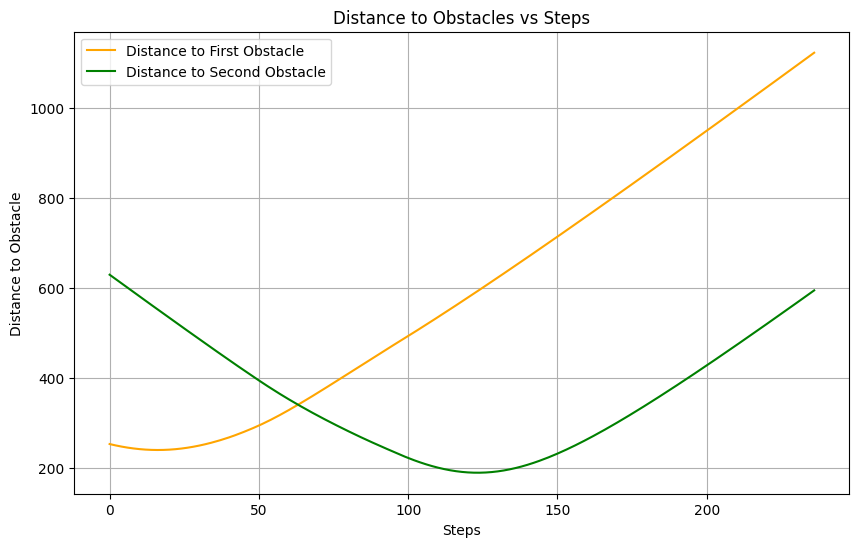

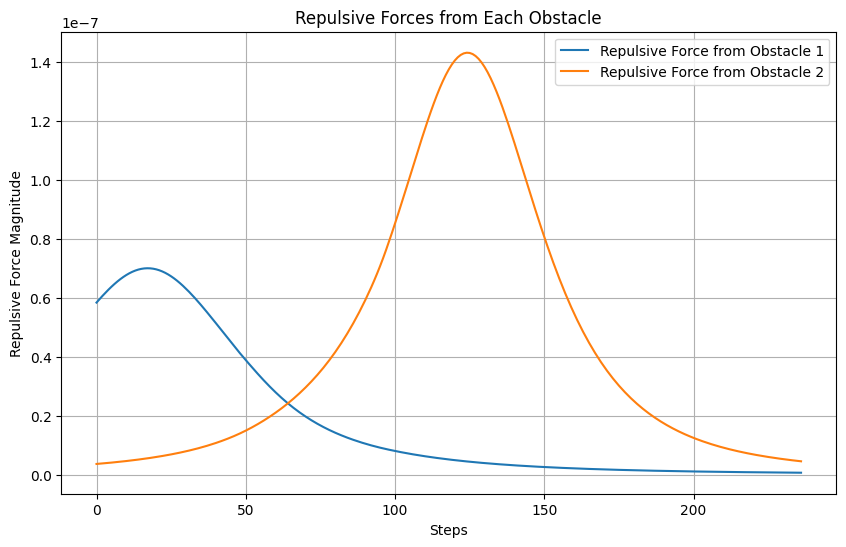

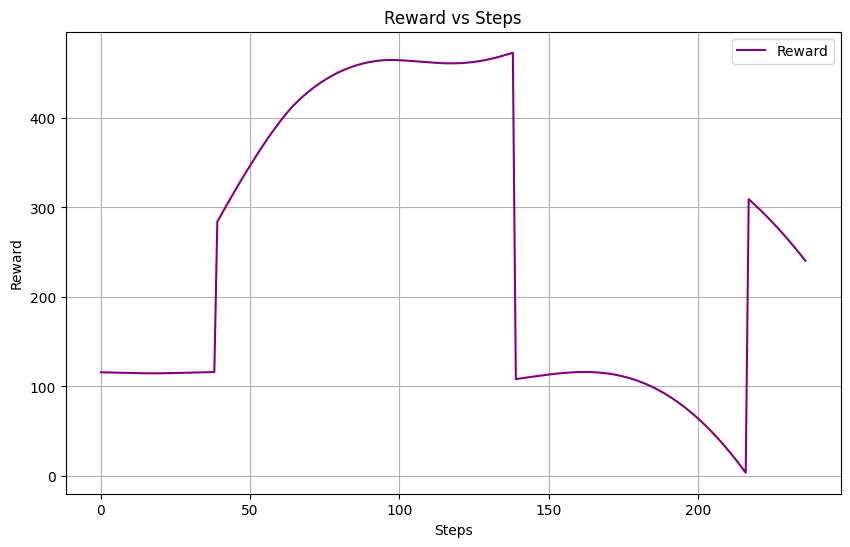

In [20]:
# Plot Distance to Obstacles
plt.figure(figsize=(10, 6))
plt.plot(range(steps), distance_to_first_obstacle, label="Distance to First Obstacle", color="orange")
plt.plot(range(steps), distance_to_second_obstacle, label="Distance to Second Obstacle", color="green")
plt.xlabel("Steps")
plt.ylabel("Distance to Obstacle")
plt.title("Distance to Obstacles vs Steps")
plt.legend()
plt.grid()
plt.show()

# Plot Repulsive Forces for Each Obstacle
plt.figure(figsize=(10, 6))
for i, obs in enumerate(obstacle_positions):
    plt.plot(range(steps), F_rep_individual[i], label=f"Repulsive Force from Obstacle {i+1}")
plt.xlabel("Steps")
plt.ylabel("Repulsive Force Magnitude")
plt.title("Repulsive Forces from Each Obstacle")
plt.legend()
plt.grid()
plt.show()

# Plot Rewards Over Steps
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label="Reward", color="purple")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Reward vs Steps")
plt.legend()
plt.grid()
plt.show()

# New Section